In [1]:
import pandas as pd

# Load data from the Parquet file
df = pd.read_parquet("data_02_00.parquet")


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7137217 entries, 0 to 7137216
Data columns (total 61 columns):
 #   Column                        Dtype         
---  ------                        -----         
 0   Event ID                      int64         
 1   Vehicle ID                    float64       
 2   Participant ID                int64         
 3   Participant type              object        
 4   Sex                           object        
 5   Driving license status        object        
 6   Years of driving experience   float64       
 7   Legal resolution              object        
 8   Killed                        object        
 9   Injured                       object        
 10  No safety equipment           object        
 11  Seat position                 object        
 12  Is at fault                   object        
 13  Under influence               object        
 14  Additional info               object        
 15  Vehicle condition             ob

In [3]:
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier
import pandas as pd
import numpy as np

# Wczytaj dane
df = pd.read_parquet("data_02_00.parquet")

# Zamiana kwartału na liczbę
df['Quarter'] = df['Quarter'].dt.quarter

# Dynamiczna lista kolumn z ID
id_columns = [col for col in df.columns if 'ID' in col]

# Ręczna czarna lista cech do wykluczenia
manual_blacklist = [
    'Killed', 'Injured',
    'Last technical inspection', 'Date of event',
    'Date of birth', 'Event date', 'Accident type'
]

# Finalna czarna lista
blacklisted_columns = manual_blacklist + id_columns

# Usunięcie kolumn z czarnej listy
df_model = df.drop(columns=blacklisted_columns)

# Podział na cechy i cel
X = df_model.drop(columns=['Injury severity']).copy()
y = df_model['Injury severity']

# Label encoding zmiennej celu
le_target = LabelEncoder()
y_encoded = le_target.fit_transform(y)

# Identyfikacja kolumn
categorical_cols = X.select_dtypes(include='object').columns.tolist()
numerical_cols = X.select_dtypes(include=np.number).columns.tolist()

# Imputacja braków
X[categorical_cols] = SimpleImputer(strategy='most_frequent').fit_transform(X[categorical_cols])
X[numerical_cols] = SimpleImputer(strategy='mean').fit_transform(X[numerical_cols])

# Label encoding zmiennych kategorycznych
for col in categorical_cols:
    X[col] = LabelEncoder().fit_transform(X[col])

# Zapewnienie formatów liczbowych
X = X.apply(pd.to_numeric)

# Model i walidacja krzyżowa
model = XGBClassifier(eval_metric='mlogloss', random_state=42)
f1_scores = cross_val_score(model, X, y_encoded, cv=5, scoring='f1_macro')
print("Macro F1-scores (5 folds):", f1_scores)
print(f"Mean macro F1-score: {f1_scores.mean():.4f}\n")

# Trenowanie modelu i ważność cech
model.fit(X, y_encoded)
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("Feature Importance:\n")
print(importance_df.to_string(index=False))


Macro F1-scores (5 folds): [0.30194766 0.18006884 0.27943476 0.33074129 0.3438258 ]
Mean macro F1-score: 0.2872

Feature Importance:

                     Feature  Importance
            Participant type    0.546004
      Driving license status    0.058486
                         Sex    0.037806
                Vehicle type    0.034457
            Legal resolution    0.032331
Protective equipment present    0.029854
               Vehicle brand    0.023835
                Other causes    0.018281
                  Crash type    0.016895
                   Area type    0.014970
                Intersection    0.013641
                 Speed limit    0.013469
             Additional info    0.011482
         No safety equipment    0.010864
                    Province    0.010479
                      Street    0.009338
             Production year    0.008998
                        Year    0.008816
                     Quarter    0.006648
                 Road number    0.006602
     

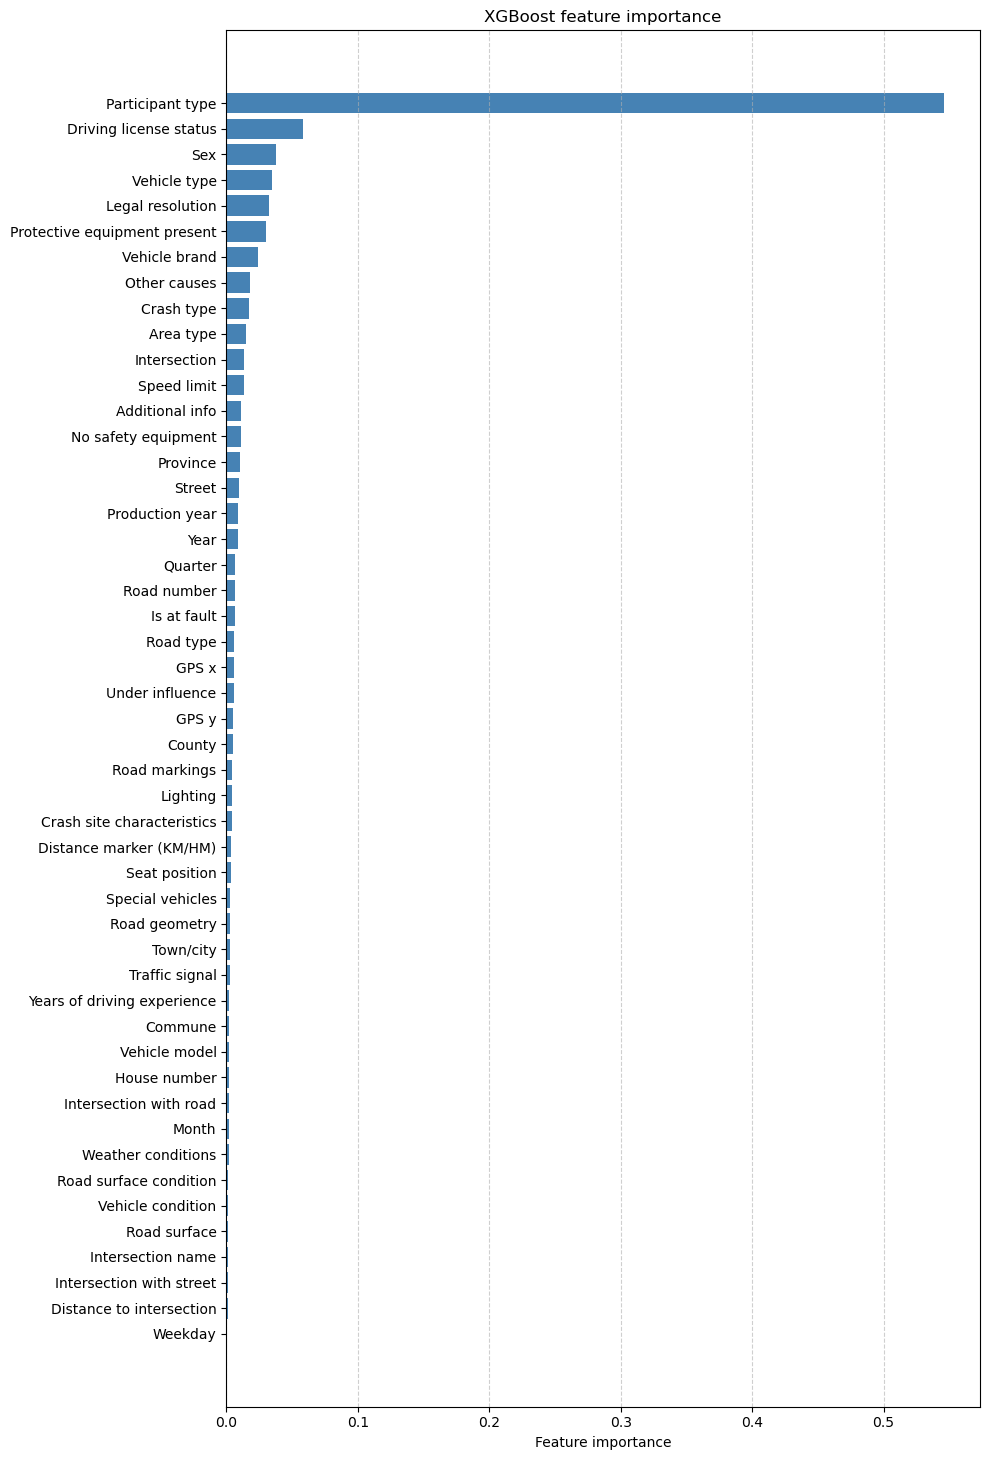

In [10]:
import matplotlib.pyplot as plt

# Sort and prepare the data
importance_df_sorted = importance_df.sort_values(by='Importance', ascending=True)

# Plot
plt.figure(figsize=(10, max(6, 0.3 * len(importance_df_sorted))))
plt.barh(importance_df_sorted['Feature'], importance_df_sorted['Importance'], color='steelblue')
plt.xlabel('Feature importance')
plt.title('XGBoost feature importance')
plt.grid(axis='x', linestyle='--', alpha=0.6)  # Add vertical gridlines
plt.tight_layout()
plt.show()